In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, explained_variance_score
# Directory paths
training_wf_dir = r'C:\Users\daddy\Downloads\archive\train\wildfire'
training_no_wf_dir = r'C:\Users\daddy\Downloads\archive\train\nowildfire'
testing_wf_dir = r'C:\Users\daddy\Downloads\archive\test\wildfire'
testing_no_wf_dir = r'C:\Users\daddy\Downloads\archive\test\nowildfire'
# Function to load and preprocess images or wrangle data
#Resize each image to 224 pixels in width to 224 pixels in length as a scaling feature
#Normalize by scaling the pixelation in each image between 0 and 1 by dividing all values by 255
#Add labels
def load_and_preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))
            image = image.astype(np.float32) / 255.0
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)
# Load and preprocess training data
X_train_wf, y_train_wf = load_and_preprocess_images(training_wf_dir, label=1)
X_train_no_wf, y_train_no_wf = load_and_preprocess_images(training_no_wf_dir, label=0)
# Load and preprocess testing data
X_test_wf, y_test_wf = load_and_preprocess_images(testing_wf_dir, label=1)
X_test_no_wf, y_test_no_wf = load_and_preprocess_images(testing_no_wf_dir, label=0)
# Combine wildfire and non-wildfire data
X_train = np.concatenate((X_train_wf, X_train_no_wf), axis=0)
y_train = np.concatenate((y_train_wf, y_train_no_wf), axis=0)
X_test = np.concatenate((X_test_wf, X_test_no_wf), axis=0)
y_test = np.concatenate((y_test_wf, y_test_no_wf), axis=0)
# Split data into training and validation sets to prevent overfitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#print the sizes of each array we've split and made
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (24200, 224, 224, 3)
Validation data shape: (6050, 224, 224, 3)
Testing data shape: (6300, 224, 224, 3)


In [2]:
# Define the CNN model
model = models.Sequential()
# Convolutional layer structure (ensuring we're not too light on the density of the network)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Fully connected layers and flattening techniques as well as dropout 
#to further address overfitting via regularization
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Display the model summary
model.summary()
# Train the model and store the historical data for its training process away for evalution later
history = model.fit(X_train, y_train, epochs=20, batch_size=500, validation_data=(X_val, y_val), verbose=2)
# Evaluate the model on the test data and examine accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
# Make predictions on the test data and convert probabilities to binary predictions as our problem is binary
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Calculate our explained variance score to assess how well the model comprehends all the conditions
explained_variance = explained_variance_score(y_test, y_pred)
print("Explained Variance Score:", explained_variance)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

A TESTING ACCURACY of 0.968 means the neural network is able to correctly classify approximately 96.87% of the images in the unseen samples from the testing dataset as either wildfire or non-wildfire.


Precision is the ratio of true positive predictions or correctly identified wildfire photos to the total number of positive predictions (both true positives and false positives). A high precision score closer to 1 or 100% indicates that when the model predicts an image as a wildfire photo, it is highly likely to be correct. In our case the model correctly identifies wildfires with a precision of approximately 98.64%.

Recall also known as sensitivity or true positive rate, is the ratio of true positive predictions to the total number of actual positive instances. It measures the model's ability to correctly capture all instances of wildfires in the dataset. Our RECALL here is 95.66%.

The F1 score is a combination of precision and recall. It provides a balance between the two metrics and is especially useful when dealing with imbalanced datasets. A higher F1 score (closer to 1) indicates a good balance between precision and recall. In tOUR case the F1 score is approximately 97.13% indicating that the model achieves a good balance between accurate wildfire predictions (precision) and capturing actual wildfires (recall).

The confusion matrix provides a detailed breakdown of the model's predictions showing the number of true positives, true negatives, false positives, and false negatives. It helps visualize more specifically where the model is making correct and incorrect predictions. Confusion matrix shows that there are 2774 true negatives (correctly identified non-wildfire photos) and 46 false positives (non-wildfire photos incorrectly classified as wildfires) and 3329 true positives (correctly identified wildfire photos) and 151 false negatives (wildfire photos classified as non-wildfire photos).

The explained variance score assesses how well the model explains the variance in the data. It measures how well the model comprehends the conditions that distinguish wildfire photos from non-wildfire photos. A score closer to 1 or 100% indicates that the model explains a significant portion of the datas variance. OUR model explains approximately 87.47% of the variance.

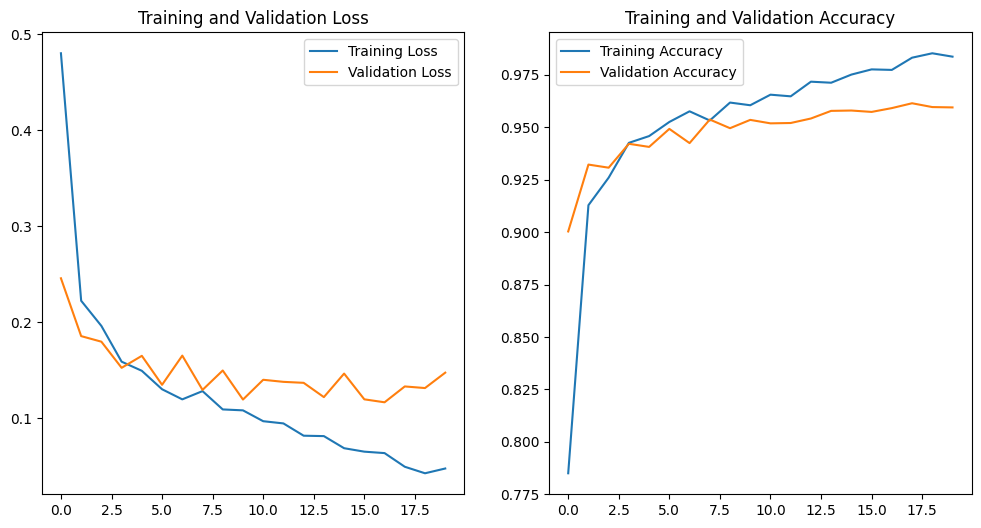

In [3]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [6]:
# Save the trained model weights for the neural network
model.save_weights('WildFireClassificationTechnology_weights.h5')
# Load the saved model weights to further test the network on UNSEEN validation data
model.load_weights('WildFireClassificationTechnology_weights.h5')
# Directory paths for unseen validation data
UNSEEN_wf_dir = r'C:\Users\daddy\Downloads\archive\valid\wildfire'
UNSEEN_no_wf_dir = r'C:\Users\daddy\Downloads\archive\valid\nowildfire'
# Re-using our earlier function to load and preprocess unseen images and create labels
def load_and_preprocess_unseen_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))
            image = image.astype(np.float32) / 255.0
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess unseen wildfire validation data and create true labels
X_unseen_wf, y_true_unseen_wf = load_and_preprocess_unseen_images(UNSEEN_wf_dir, label=1)
# Load and preprocess unseen non-wildfire validation data and create  false labels
X_unseen_no_wf, y_true_unseen_no_wf = load_and_preprocess_unseen_images(UNSEEN_no_wf_dir, label=0)
# Make predictions on the unseen validation data
y_pred_unseen_wf = model.predict(X_unseen_wf)
y_pred_unseen_no_wf = model.predict(X_unseen_no_wf)
# Convert probabilities to binary predictions as we did before
y_pred_unseen_wf = (y_pred_unseen_wf > 0.5)
y_pred_unseen_no_wf = (y_pred_unseen_no_wf > 0.5)
# Calculate accuracy for validation wildfire data
accuracy_unseen_wf = accuracy_score(y_true_unseen_wf, y_pred_unseen_wf)
print("Accuracy for Wildfire Images:", accuracy_unseen_wf)
# Calculate accuracy for validation non-wildfire data
accuracy_unseen_no_wf = accuracy_score(y_true_unseen_no_wf, y_pred_unseen_no_wf)
print("Accuracy for Non-Wildfire Images:", accuracy_unseen_no_wf)

89/89 [==============================] - 14s 157ms/step
Accuracy for Wildfire Images: 0.9534482758620689
Accuracy for Non-Wildfire Images: 0.9726950354609929


IN THE VALIDATION DATA, We see we correctly predicted wild fire images 95.3% of the time while we correctly predicted non-wild fire images 97.2% of the time. VERY GOOD NUMBERS.

1/1 [==============================] - 0s 29ms/step


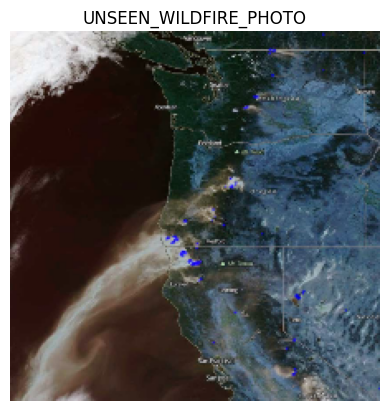

The neural network thinks UNSEEN_WILDFIRE_PHOTO is a wildfire.


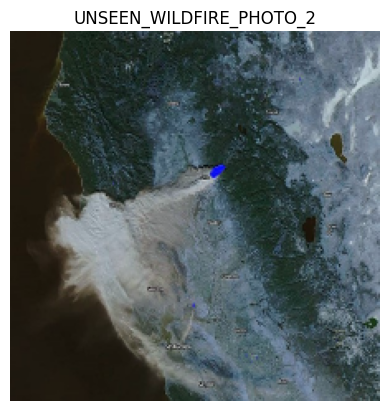

The neural network thinks UNSEEN_WILDFIRE_PHOTO_2 is a wildfire.


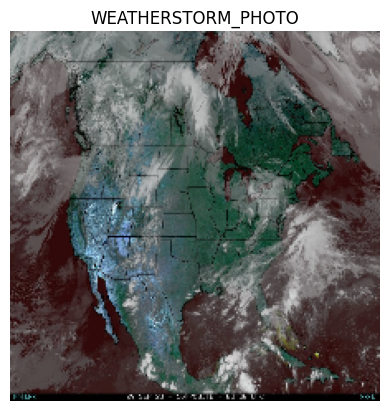

The neural network thinks WEATHERSTORM_PHOTO is not a wildfire.


In [7]:
import matplotlib.pyplot as plt
# Load the saved model weights again so we can test on 3 random images from live satellite feeds
model.load_weights('WildFireClassificationTechnology_weights.h5')
# Define paths to unseen live-satellite images
UNSEEN_WILDFIRE_PHOTO = r'C:\Users\daddy\Downloads\Smoke_NWfires.jpg'
UNSEEN_WILDFIRE_PHOTO_2 = r'C:\Users\daddy\Downloads\wildfire2.jpg'
WEATHERSTORM_PHOTO = r'C:\Users\daddy\Downloads\WeatherStorm.jpg'
# Function to load and preprocess the 3 unseen images
def load_and_preprocess_unseen_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32) / 255.0 
    return image
# Load and preprocess the unseen wildfire photos
unseen_wf_photo = load_and_preprocess_unseen_image(UNSEEN_WILDFIRE_PHOTO)
unseen_wf_photo_2 = load_and_preprocess_unseen_image(UNSEEN_WILDFIRE_PHOTO_2)
# Load and preprocess the weatherstorm photo
weatherstorm_photo = load_and_preprocess_unseen_image(WEATHERSTORM_PHOTO)
# Make predictions on the unseen photos
pred_unseen_wf = model.predict(np.expand_dims(unseen_wf_photo, axis=0))
pred_unseen_wf_2 = model.predict(np.expand_dims(unseen_wf_photo_2, axis=0))
pred_weatherstorm = model.predict(np.expand_dims(weatherstorm_photo, axis=0))
# Convert probabilities to binary predictions
is_wf_unseen_wf = pred_unseen_wf > 0.5
is_wf_unseen_wf_2 = pred_unseen_wf_2 > 0.5
is_wf_weatherstorm = pred_weatherstorm > 0.5
# Function to display an image
def show_image(image, title):
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()
# Show and print the first image
show_image(unseen_wf_photo, "UNSEEN_WILDFIRE_PHOTO")
if is_wf_unseen_wf:
    print("The neural network thinks UNSEEN_WILDFIRE_PHOTO is a wildfire.")
else:
    print("The neural network thinks UNSEEN_WILDFIRE_PHOTO is not a wildfire.")
# Show and print the second image
show_image(unseen_wf_photo_2, "UNSEEN_WILDFIRE_PHOTO_2")
if is_wf_unseen_wf_2:
    print("The neural network thinks UNSEEN_WILDFIRE_PHOTO_2 is a wildfire.")
else:
    print("The neural network thinks UNSEEN_WILDFIRE_PHOTO_2 is not a wildfire.")
# Show and print the third image
show_image(weatherstorm_photo, "WEATHERSTORM_PHOTO")
if is_wf_weatherstorm:
    print("The neural network thinks WEATHERSTORM_PHOTO is a wildfire.")
else:
    print("The neural network thinks WEATHERSTORM_PHOTO is not a wildfire.")

AND AS WE CAN SEE FROM ABOVE ON 3 BRAND NEW AND UNSEEN SATELLITE IMAGES, THE NEURAL NETWORK THOROUGHLY COMPREHENDS THE DATA AND PROBLEM AS WELL AS ITS SOLUTION (Predicting wild fires) AND IS ABLE TO DISTINGUISH WITH GREAT ACCURACY BETWEEN WILD FIRE PHOTOS AND ANY OTHER TYPE OF DISAASTER AS WELL AS NORMAL SATELLITE IMAGERY. 